In [3]:
import graphlab
import math
import random
import numpy
from matplotlib import pyplot as plt
%matplotlib inline

This non-commercial license of GraphLab Create for academic use is assigned to workingjhy@gmail.com and will expire on July 31, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1487661364.log
/Users/jihaoyu/anaconda/envs/gl-env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
random.seed(98103)
n = 30
x = graphlab.SArray([random.random() for i in range(n)]).sort()


In [5]:
y = x.apply(lambda x:math.sin(4*x))

In [6]:
#add some noise to the data
random.seed(1)
e = graphlab.SArray([random.gauss(0,1.0/3.0) for i in range(n)])
y = y = e

In [7]:
#put data into an SFrame to manipulate later
data = graphlab.SFrame({'X1':x, 'Y':y})
data

X1,Y
0.0395789449501,0.429394917718
0.0415680996791,0.483148536233
0.0724319480801,0.0221119363128
0.150289044622,-0.254847883657
0.161334144502,-0.364057738368
0.191956312795,0.0104448389439
0.232833917145,-0.34070105667
0.259900980166,-0.478943148368
0.380145814869,0.0664373254946
0.432444723508,0.0444582015529


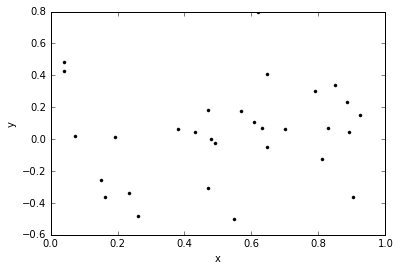

In [8]:
def plot_data(data):
    plt.plot(data['X1'], data['Y'],'k.')
    plt.xlabel('x')
    plt.ylabel('y')

plot_data(data)

In [9]:
#define some useful polynomial regression functions
# def polynomial_features(data, deg):
#     data_copy = data.copy()
#     for i in range(1, deg):
#         data_copy['X'+str(i+1)] = data_copy['X'+str(i)]*data_copy['X1']
#     return data_copy
def polynomial_features(data, deg):
    data_copy=data.copy()
    for i in range(1,deg):
        data_copy['X'+str(i+1)]=data_copy['X'+str(i)]*data_copy['X1']
    return data_copy

In [10]:
# def polynomial_regression(data, deg):
#     model = graphlab.linear_regression.create(polynomial_features(data, deg),
#                                              target = 'Y', l2_penalty = 0., l1_penalty = 0.,
#                                              validation_set = None)
#     return model

def polynomial_regression(data, deg):
    model = graphlab.linear_regression.create(polynomial_features(data,deg), 
                                              target='Y', l2_penalty=0.,l1_penalty=0.,
                                              validation_set=None,verbose=False)
    return model

In [11]:
# def plot_poly_predictions(data, model):
#     plot_data(data)
    
#     # Get the degree of the polynomial
#     deg = len(model.coefficients['value']) - 1
    
#     # Create 200 points in the x axis and compute the predicted value for each point
#     x_pred = graphlab.SFrame({'X1': [i/200.0 for i in range(200)]})
#     y_pred = model.predict(polynomial_features(x_pred, deg))
    
#     # plot predictions
#     plt.plot(x_pred['X1'], y_pred, 'g-', label = 'degree' +str(deg) + ' fit')
#     plt.legend(loc = 'upper left')
#     plt.axis([0, 1, -1.5, 2])

def plot_poly_predictions(data, model):
    plot_data(data)

    # Get the degree of the polynomial
    deg = len(model.coefficients['value'])-1
    
    # Create 200 points in the x axis and compute the predicted value for each point
    x_pred = graphlab.SFrame({'X1':[i/200.0 for i in range(200)]})
    y_pred = model.predict(polynomial_features(x_pred,deg))
    
    # plot predictions
    plt.plot(x_pred['X1'], y_pred, 'g-', label='degree ' + str(deg) + ' fit')
    plt.legend(loc='upper left')
    plt.axis([0,1,-1.5,2])

In [12]:
def print_coefficients(model):
    # Get the degree of the polynomial
    deg = len(model.coefficients['value'])-1
    # Get learned parameters as a list
    w = list(model.coefficients['value'])
    
    # Numpy has a nifty function to print out polynomials in a pretty  way
    # it needs the parameters in the reverse order
    print 'Learned polynomial for degree' + str(deg) +':'
    w.reverse()
    print numpy.poly1d(w)

# Fit a degree-2 polynomial

In [13]:
model = polynomial_regression(data, deg = 2)

Inspect learned parameters

In [14]:
print_coefficients(model)

Learned polynomial for degree2:
        2
0.6037 x - 0.4378 x + 0.05847


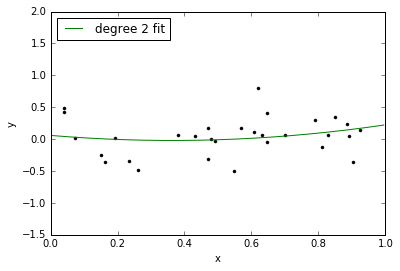

In [15]:
plot_poly_predictions(data, model)

Learned polynomial for degree4:
      4         3         2
15.3 x - 40.37 x + 35.12 x - 10.89 x + 0.7792


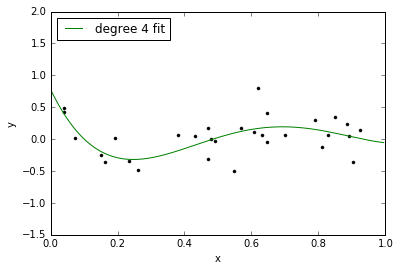

In [16]:
model4 = polynomial_regression(data, deg = 4)
print_coefficients(model4)
plot_poly_predictions(data, model4)

Learned polynomial for degree16:
           16             15             14             13
2.583e+06 x  - 1.092e+07 x  + 1.443e+07 x  + 1.873e+06 x 
              12             11             10             9
 - 2.095e+07 x  + 1.295e+07 x  + 9.366e+06 x  - 1.232e+07 x
              8             7             6             5             4
 - 2.544e+06 x + 1.181e+07 x - 9.325e+06 x + 3.887e+06 x - 9.666e+05 x
              3             2
 + 1.441e+05 x - 1.215e+04 x + 502.6 x - 7.325


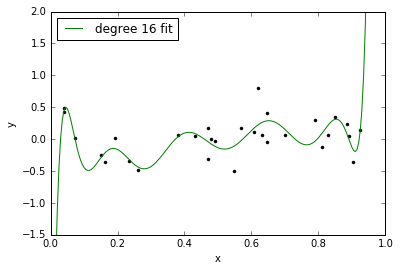

In [17]:
model16 = polynomial_regression(data, deg = 16)
print_coefficients(model16)
plot_poly_predictions(data, model16)

# Ridge Regression

In [18]:
def polynomial_ridge_regression(data, deg, l2_penalty):
    model = graphlab.linear_regression.create(polynomial_features(data,deg),
                                             target = 'Y', l2_penalty=l2_penalty,
                                             validation_set = None, verbose = False)
    return model

In [19]:
model = polynomial_ridge_regression(data, deg = 16, l2_penalty = 1e-25)# a small penalty
print_coefficients(model)

Learned polynomial for degree16:
           16             15             14             13
2.583e+06 x  - 1.092e+07 x  + 1.443e+07 x  + 1.873e+06 x 
              12             11             10             9
 - 2.095e+07 x  + 1.295e+07 x  + 9.366e+06 x  - 1.232e+07 x
              8             7             6             5             4
 - 2.544e+06 x + 1.181e+07 x - 9.325e+06 x + 3.887e+06 x - 9.666e+05 x
              3             2
 + 1.441e+05 x - 1.215e+04 x + 502.6 x - 7.325


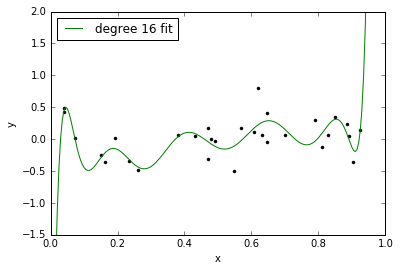

In [20]:
plot_poly_predictions(data, model)

In [21]:
model = polynomial_ridge_regression(data, deg = 16, l2_penalty = 100)
print_coefficients(model)

Learned polynomial for degree16:
          16           15           14           13           12
-0.02904 x  - 0.02386 x  - 0.01898 x  - 0.01438 x  - 0.01003 x 
             11            10            9            8            7
 - 0.005893 x  - 0.001938 x  + 0.001863 x + 0.005523 x + 0.009031 x
            6           5           4           3           2
 + 0.01232 x + 0.01521 x + 0.01728 x + 0.01767 x + 0.01467 x + 0.00631 x + 0.02253


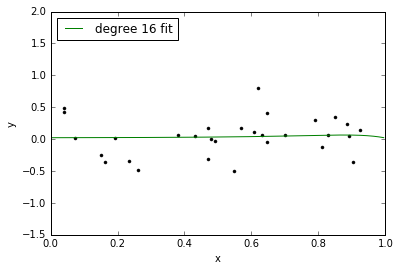

In [22]:
plot_poly_predictions(data, model)

lambda = 1.00e-25
Learned polynomial for degree16:
           16             15             14             13
2.583e+06 x  - 1.092e+07 x  + 1.443e+07 x  + 1.873e+06 x 
              12             11             10             9
 - 2.095e+07 x  + 1.295e+07 x  + 9.366e+06 x  - 1.232e+07 x
              8             7             6             5             4
 - 2.544e+06 x + 1.181e+07 x - 9.325e+06 x + 3.887e+06 x - 9.666e+05 x
              3             2
 + 1.441e+05 x - 1.215e+04 x + 502.6 x - 7.325


lambda = 1.00e-10
Learned polynomial for degree16:
           16             15             14             13
4.975e+04 x  - 7.821e+04 x  - 2.265e+04 x  + 3.949e+04 x 
              12        11             10             9             8
 + 4.366e+04 x  + 3079 x  - 3.333e+04 x  - 2.785e+04 x + 1.032e+04 x
              7        6             5             4        3         2
 + 2.963e+04 x - 1443 x - 2.598e+04 x + 1.839e+04 x - 5585 x + 866.1 x - 69.19 x + 2.159


lambda = 1.00e-06
L

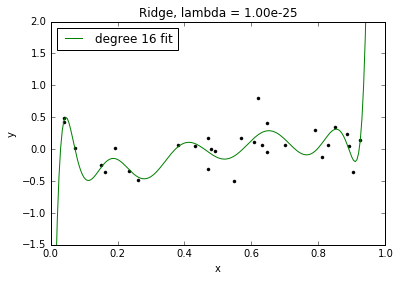

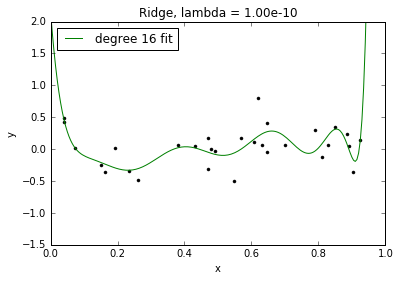

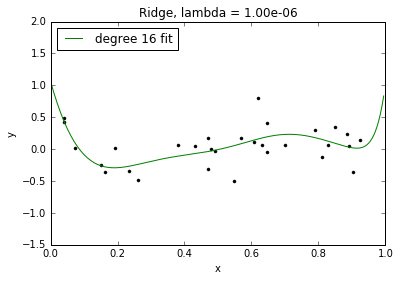

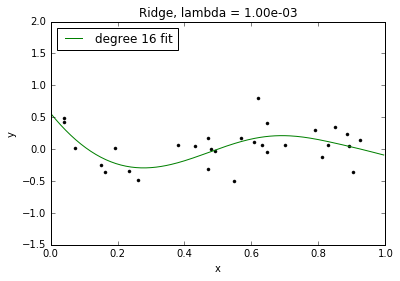

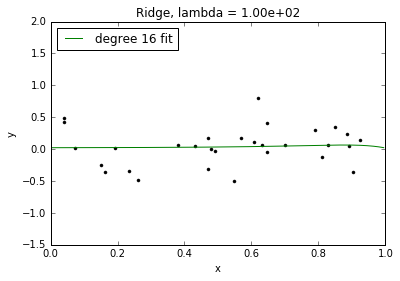

In [23]:
for l2_penalty in[1e-25, 1e-10, 1e-6, 1e-3, 1e2]:
    model = polynomial_ridge_regression(data, deg = 16, l2_penalty = l2_penalty)
    print 'lambda = %.2e' % l2_penalty
    print_coefficients(model)
    print '\n'
    plt.figure()
    plot_poly_predictions(data, model)
    plt.title('Ridge, lambda = %.2e' % l2_penalty)

# LOO (Leave one out) cross calidation

In [30]:
# def loo(data, deg, l2_penalty_values):
#     # Create polynomial features
#     data = polynomial_features(data, deg)
    
#     #Create as many folds for cross validation as number of data points
#     num_folds = len(data)
#     folds = graphlab.cross_validation.KFold(data, num_folds)
    
#     # for each value of l2_penalty, fit a model for each fold and compute average MSE
#     l2_penalty_mse = []
#     min_mse = None
#     best_l2_penalty = None
#     for l2_penalty in l2_penalty_values:
#         next_mse = 0.0
#         for train_set, validation_set in folds:
#             #train model
#             model = graphlab.linear_regression.create(train_set, target = 'Y',
#                                                      l2_penalty = l2_penalty, 
#                                                      validation_set = None, verbose = False)
#             # predict on validation set
#             y_test_predicted = model.predict(validation_set)
#             #compute squared error
#             next_mse += ((y_test_predicted - validation_set['Y']) ** 2).sum()
#         # save squared error in list of MSE for each l2_penalty
#         next_mse = next_mse / num_folds
#         l2_penalty_mse.append(next_mse)
#         if min_mse is None or next_mse < min_mse:
#             min_mse = next_mse
#             best_l2_penalty = l2_penalty
            
#     return l2_penalty_mse, best_l2_penalty
# LOO cross validation -- return the average MSE
def loo(data, deg, l2_penalty_values):
    # Create polynomial features
    data = polynomial_features(data, deg)
    
    # Create as many folds for cross validatation as number of data points
    num_folds = len(data)
    folds = graphlab.cross_validation.KFold(data,num_folds)
    
    # for each value of l2_penalty, fit a model for each fold and compute average MSE
    l2_penalty_mse = []
    min_mse = None
    best_l2_penalty = None
    for l2_penalty in l2_penalty_values:
        next_mse = 0.0
        for train_set, validation_set in folds:
            # train model
            model = graphlab.linear_regression.create(train_set,target='Y', 
                                                      l2_penalty=l2_penalty,
                                                      validation_set=None,verbose=False)
            
            # predict on validation set 
            y_test_predicted = model.predict(validation_set)
            # compute squared error
            next_mse += ((y_test_predicted-validation_set['Y'])**2).sum()
        
        # save squared error in list of MSE for each l2_penalty
        next_mse = next_mse/num_folds
        l2_penalty_mse.append(next_mse)
        if min_mse is None or next_mse < min_mse:
            min_mse = next_mse
            best_l2_penalty = l2_penalty
            
    return l2_penalty_mse,best_l2_penalty

In [31]:
l2_penalty_values = numpy.logspace(-4, 10, num = 10)
l2_penalty_mse, best_l2_penalty = loo(data, 16, l2_penalty_values)

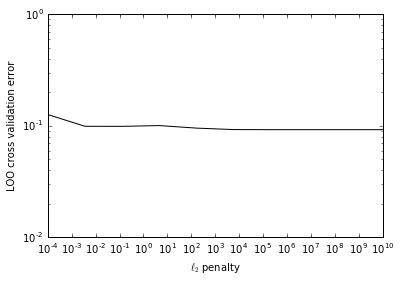

In [28]:
plt.plot(l2_penalty_values, l2_penalty_mse, 'k-')
plt.xlabel('$\ell_2$ penalty')
plt.ylabel('LOO cross validation error')
plt.xscale('log')
plt.yscale('log')

In [32]:
best_l2_penalty

10000000000.0

In [33]:
model = polynomial_ridge_regression(data, deg = 16, l2_penalty = best_l2_penalty)
print_coefficients(model)

Learned polynomial for degree16:
           16             15             14            13
6.387e-11 x  + 8.781e-11 x  + 1.105e-10 x  + 1.32e-10 x 
              12             11             10             9
 + 1.526e-10 x  + 1.724e-10 x  + 1.916e-10 x  + 2.104e-10 x
              8             7             6             5             4
 + 2.287e-10 x + 2.462e-10 x + 2.619e-10 x + 2.735e-10 x + 2.762e-10 x
              3             2
 + 2.602e-10 x + 2.071e-10 x + 9.6e-11 x + 0.04034


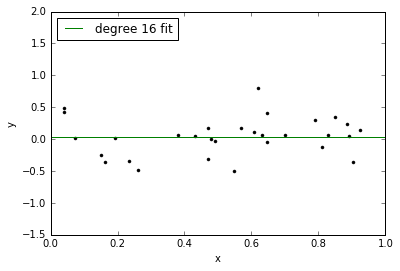

In [34]:
plot_poly_predictions(data, model)